# Criptografia quântica
## Simulação do protocolo BB84 no IBMQ

O protocolo quântico para distribuição de chaves criptográficas proposto por Bennett e Brassard em 1984 (BB84) funciona da seguinte forma. Alice e Bob querem compartilhar uma chave criptográfica, ou seja, eles querem compartilhar uma sequência de bits (zeros e uns) aleatórios, de forma que ninguém mais consiga ter acesso a essa chave. Ademais, se alguém tentar descobrir a chave, pelo sistema físico ser quântico, este será perturbado e Alice e Bob perceberão isso, não usando a dita chave para comunicação. 

* No BB84, Alice começa preparando, de forma aleatória e com mesma probabilidade, um dos 4 estados:
$$\{|0\rangle,|1\rangle,|+\rangle,|-\rangle\},$$
em que $\{|0\rangle,|1\rangle\}$ são autovetores do observável
$$Z = \begin{bmatrix}1&0\\0&-1\end{bmatrix} = (+1)|0\rangle\langle 0| + (-1)|1\rangle\langle 1|$$
enquanto que $\{|+\rangle,|-\rangle\}$, com
$$|\pm\rangle = 2^{-1/2}\big(|0\rangle\pm|1\rangle\big),$$
são autovetores do observável
$$X = \begin{bmatrix}0&1\\1&0\end{bmatrix} = (+1)|+\rangle\langle +| + (-1)|-\rangle\langle -|.$$

* Depois de ter preparado um desses 4 estados, Alice envia o qubit para Bob. 

No meio do caminho, a espiã, Eva, pode tentar descobrir qual foi o estado enviado por Alice. No entanto, para isso ela terá que medir o qubit, mudando assim, em geral, seu estado. 

* De qualquer modo, Bob, ao receber esse qubit, escolhe, de forma aleatória e equiprovável, medir o observável $Z$ ou $X.$
Note que se Bob tem $50\ \%$ de chance de escolher um observável tal que o estado preparado por Alice é autovetor desse observável.
Por exemplo, se Alice preparou o estado $|0\rangle$ e Bob mediu o observável $Z$, ele certamente obterá o valor $+1$, que corresponde ao autovetor $|0\rangle$. No entanto, se Bob escolheu medir o observável $X$, ele obterá os valores (estados) $+1\ (|+\rangle)$ e $-1\ (|-\rangle)$ com igual chance, pois $|0\rangle=2^{-1/2}(|+\rangle+|-\rangle)$. 
Do mesmo modo, se Alice preparou o estado $|1\rangle$ e Bob mediu o observável $Z$, ele certamente obterá o valor (estado) $-1\ (|1\rangle)$. No entanto, se Bob escolheu medir o observável $X$, ele obterá os valores (estados) $+1\ (|+\rangle)$ e $-1\ (|-\rangle)$ com a mesma probabilidade, pois $|1\rangle=2^{-1/2}(|+\rangle-|-\rangle)$.
Também, se Alice preparou o estado $|+\rangle$ e Bob mediu o observável $X$, ele certamente obterá o valor (estado) $+1\ (|+\rangle)$. No entanto, se Bob escolheu medir o observável $Z$, ele obterá os valores (estados) $+1\ (|0\rangle)$ e $-1\ (|1\rangle)$ com a mesma probabilidade, pois $|+\rangle=2^{-1/2}(|0\rangle+|1\rangle)$.
Com uma última possibilidade, se Alice preparou o estado $|-\rangle$ e Bob mediu o observável $X$, ele certamente obterá o valor (estado) $-1\ (|-\rangle)$. No entanto, se Bob escolheu medir o observável $Z$, ele obterá os valores (estados) $+1\ (|0\rangle)$ e $-1\ (|1\rangle)$ com a mesma probabilidade, pois $|-\rangle=2^{-1/2}(|0\rangle-|1\rangle)$.

* Esse procedimento:
$$\text{preparação de Alice - envio do qubit - medida de Bob},$$
é repetido um número $N$ (grande) de vezes. Feito isso, Bob envia para Alice um vetor 
$$\vec{m}^B$$
cujas componentes são bits de informação clássica (cbits) e informam Alice qual foi a escolha de observável dele para cada um dos qubits que ela enviou pra ele. Por exemplo, Alice e Bob podem combinar a seguinte associação de valor de cbit com o observável medido por Bob:
\begin{align}
Z \rightarrow 0, \\
X \rightarrow 1.
\end{align}
Alice e Bob também convencionam que, para comparação, Alice irá usar um vetor
$$\vec{p}^A$$
cujas componentes são cbits que guardam informação de se o estado que foi preparado por Alice é autovetor de $Z$ ou de $X$:
\begin{align}
|0\rangle,|1\rangle \rightarrow 0, \\
|+\rangle,|-\rangle \rightarrow 1.
\end{align}
Com isso, Alice obtém um vetor de comparação fazendo a soma binária dos vetores componente a componente:
$$\vec{c} = \vec{m}^B \oplus \vec{p}^A.$$
Ou seja
$$c_j = (m^B_j + p^A_j)\mod 2.$$
Se a escolha de Alice e Bob foi a "mesma", então $c_j = 0$, se foi diferente então $c_j=1$.

In [7]:
from qiskit import *
import numpy as np
import math
import qiskit
nshots = 8192
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_manila')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram

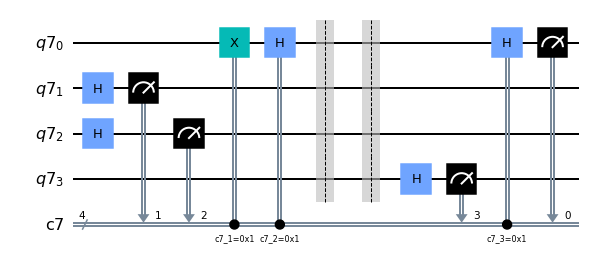

In [16]:
def qc_bb84():
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr,cr)
    qc.h([1,2])
    qc.measure([1,2],[1,2])
    qc.x(0).c_if(cr[1],1)
    qc.h(0).c_if(cr[2],1)
    qc.barrier()
    qc.barrier()
    qc.h(3)
    qc.measure(qr[3],cr[3])
    qc.h(0).c_if(cr[3],1)
    qc.measure(0,0)
    return qc
qc_bb84_ = qc_bb84(); qc_bb84_.draw('mpl')

In [31]:
nshots = 1
N = 100
counts = []
for j in range(0,N):
    job_sim = execute(qc, backend=simulator, shots=nshots)
    counts_sim = job_sim.result().get_counts(qc)
    counts.append(counts_sim)
counts[0:5]

[{'0000': 1}, {'1100': 1}, {'1010': 1}, {'0110': 1}, {'0000': 1}]

In [39]:
counts_keys = [j for j in counts]
counts_keys

[{'0000': 1},
 {'1100': 1},
 {'1010': 1},
 {'0110': 1},
 {'0000': 1},
 {'0000': 1},
 {'0011': 1},
 {'0101': 1},
 {'1000': 1},
 {'0101': 1},
 {'0011': 1},
 {'1001': 1},
 {'1100': 1},
 {'1111': 1},
 {'1111': 1},
 {'0011': 1},
 {'1011': 1},
 {'0110': 1},
 {'0000': 1},
 {'1100': 1},
 {'1000': 1},
 {'0011': 1},
 {'1011': 1},
 {'0000': 1},
 {'0111': 1},
 {'1000': 1},
 {'1001': 1},
 {'0011': 1},
 {'1010': 1},
 {'0110': 1},
 {'0000': 1},
 {'1001': 1},
 {'0000': 1},
 {'0100': 1},
 {'1111': 1},
 {'0110': 1},
 {'1010': 1},
 {'0000': 1},
 {'1111': 1},
 {'1000': 1},
 {'0011': 1},
 {'1100': 1},
 {'0000': 1},
 {'0011': 1},
 {'0011': 1},
 {'1000': 1},
 {'1111': 1},
 {'1100': 1},
 {'1100': 1},
 {'0011': 1},
 {'1100': 1},
 {'1100': 1},
 {'1010': 1},
 {'1001': 1},
 {'0000': 1},
 {'0000': 1},
 {'1011': 1},
 {'1011': 1},
 {'1100': 1},
 {'0011': 1},
 {'0111': 1},
 {'0111': 1},
 {'0011': 1},
 {'1100': 1},
 {'1100': 1},
 {'1111': 1},
 {'0011': 1},
 {'0000': 1},
 {'1111': 1},
 {'0100': 1},
 {'0000': 1},
 {'001

In [25]:
k=0;l=1;m=0;n=0
s= str(k)+str(l)+str(m)+str(n)
s

'0100'

In [29]:
eo = [] # observavel escolhido por Alice e Bob (mesmo = 0, diferente=1)
for j in range(0,N):
    for k in range(0,2):
        for l in range(0,2):
            for m in range(0,2):
                for n in range(0,2):
                    s = str(n) + str(m) + str(l) + str(k)
                    if counts[j][s] in counts and  counts[j][s] == 1:
                        if l==0 and m==0:
                            eo.append(0)
                        else:
                            eo.append(1)
eo
                        

KeyError: '0000'

In [ ]:
qr = QuantumRegister(4)
